# Review of Time Series for Machine Learning

## Organization:

1. Key factors that distinguish time-series from other random processes.
2. Examples of time series, applying the two keys to these examples.
2. Autocorrelation function of time series. Basic notions of stationarity and second-order properties.
3. Modeling: How to create different time-series models:

    a. Normal time series: generating Gaussian processes with desired statistics in NumPy.
    
    b. Coloring: Karhunen Loeve expansion to get a desired time-series correlation pattern.
    
    c. Random walks! 
    
    d. Markov chains and processes.
    
    e. Auto-Regressive (AR) models, touch upon ARMA models. 
    
    f. Brownian motion: limiting behavior of Random Walks
        
4. Regression: after we've generated a time-series model, what can be done?

    a. Key point: regression strategy depends on structure of time-series model (order, memory, periodicity, etc.)
    
    b. Bias-Variance trade-off: ultimate struggle for optimum model

5. Main application in Machine Learning: Predicting the future!

     a. Least Squares prediction
     
     b. Recursive (adaptive) prediction 


### Key factors that distinguish time-series from other random processes

A Time Series can be thought of as a sequence of random variables indexed in time. These variables usually share a common structure, and normally benefit from two interrelated properties:

### 1. A sequential/causal structure: 

The concept that "before" influences "after" but not vice versa. Contrast this with sequences that are a function of space such as temperature across the state, or pixels in an image. In that case for instance, it is meaningful to talk about finding an average color value at coordinate $(x,y)$ by looking at the points before and after the point, $(x-1,y)$, $(x+1,y)$. In time series, all the stakes are at knowing or predicting the future point, such as the value of a particular stock tomorrow. This may hint to causality but we should be cautious to assume that a variable or event at time $[t]$ "causes" the variable or event at time $[t+1]$. Time usually is a latent vairiable used merely to index the sequence of events, not to physically cause them.



In [1]:
%matplotlib inline
from IPython.display import Image
#Image(filename='my_photo.jpeg', width=600)
Image(url='http://jasss.soc.surrey.ac.uk/10/2/7/Figure_12.JPG')

In [2]:
Image(url='http://tnlandforms.us/at/atelev1.jpg')

In [3]:
Image(url='http://what-when-how.com/wp-content/uploads/2012/07/tmp26dc134_thumb.png')

### 2. A locality structure:

To a fairly general degree, events closer in time tend to be more intertwined than events occuring further in time. The temperature of a room at 9:03 am is assumed closer to the temperature at time 9:05 am compared to 6:00 am or 4:00 pm, and the values of the stocks today are better indicators of the stock market performance tomorrow then perhaps the stock values recorded ten days ago. This closeness can be quantified by particular measures such as autocorrelation, entropy rate, state, memory, filter order, etc. Note however that some richer structure might override this localitiy principle. A good example of this is periodicity. Although the temperature values in December 2015 are closer in time to temperature values in April 2016 compared to temperature values in April 2015, due to the periodic nature of seasons we might be better off relying on those values to predict the future temperature in April. 



## Example of a time series in Pandas

Original number of sample points:  72
Number of samples after conversion:  143


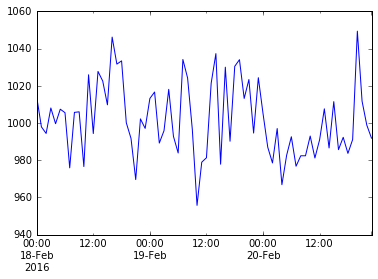

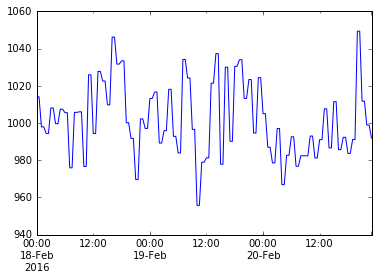

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

time_range = pd.date_range('2/18/2016', periods=72, freq='H') # 48 hour span
ts = pd.Series(1000+20*np.random.randn(len(time_range)), index=time_range)
ts.plot()
ts_converted = ts.asfreq('30Min', method='pad')
plt.figure()
ts_converted.plot()
print 'Original number of sample points: ', len(ts)
print 'Number of samples after conversion: ', len(ts_converted)
#ts.resample('D', how='mean').plot()

## Generating Gaussian sequences with desired pearson correlation:

Actual correlation 0.749186202743


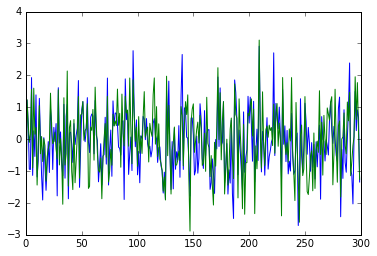

In [15]:
desired_correlation = 0.75
num_samples = 300

data = np.random.multivariate_normal([0, 0], [[1, desired_correlation], [desired_correlation, 1]], size = num_samples)
X, Y = data[:,0], data[:,1]

import scipy.stats as stats
import matplotlib.pyplot as plt

print 'Actual correlation', stats.pearsonr(X, Y)[0]
plt.plot(X)
plt.plot(Y)


### Coloring with Karhunen-Loeve: How to generate a time series with desired autocorrelation

Suppose you want to generate a sequence of random variables with an autocorrelation between its samples given by a desired matrix $C$. A neat way to do this is to start with an uncorrelated sequence $X=\{x_1,x_2,...,x_n\}$, and then to find a linear transformation $A(X)$ acting on the uncorrelated sequence such that the output of the transformation $Y$ has the desired correlation structure! When a process is uncorrelated and has equal variances, we call it a white process because it has a flat spectrum (all frequencies exist with equal distrubution, similar to natural light). Transforming it using $A(X)$ correponds to filtering out bands in the frequency domain, which results in a non-flat spectrum. The output process $Y$ is now colored!

Mathematically speaking, say we represented the linear transformation by a matrix $A$. If we inject a sequence (or vector) $X$ into the transform $A$, we get an output $Y=AX$. By some manipulations, we know that the covariance matrix of a linear transformation is $C_y = A^{T}C_x A$. Let's assume $X$ is white. In that case, $C_x = \sigma I$, a scaled identity matrix, which gives us an equivalent to $C_y = A^{T}A$. The objective now is to find (or design) $A$ to get the desired covariance matrix $C_y$, that is, find $A$ such that:

$$ C_y = A^{T}A = U_y \Lambda_{y} U_{y}^{T} $$,

where $U_y$ is a unitary matrix containing the eigenvectors of the covariance matrix $C_y$, and $\Lambda_y$ is a diagonal matrix of its eigenvalues. This is a fundamental equation in statisitics, machine learning, and signal processing. Decomposing a covariance matrix and looking into its dominant eigenvectors is one of the most valuable and recurring tools in many applications.

Incidentally, there is an entire class of such matrices $A$ that satisfy the equation above. If we choose $$A=\Lambda_{y}^{1/2} U_{y}^{T}$$, then we can easily see that $A^{T}A=U_{y}\Lambda_{y}^{1/2}\Lambda_{y}^{1/2}U_{y}^{T}=U_{y}\Lambda_{y}U_{y}^{T}=C_y$, and that's exactly what we need! So in a nutshell, generate a white sequence of uncorrelated random samples, multiply them by the matrix $A$ derived above, and the output of this simple filter will be a sequence of correlated random variables with the desired covariance matrix $C_y$.

The strategy outlined above is for block-by-block manipulation, and is a simplification of the broader KL-expansion criterion for random processes that we will not cover here.


### Note: Toeplitz, Circulant, and Symmetric Covariance Matrices:

For most practical situations, you will encounter covariance matrices as symmetric (or Hermitian, if they're complex) matrices with real eigenvalues, and more often than not, thier diagonal values (corresponding to the variances of each sample) are the dominant values in the matrix, with the remaining values tending to diminish as we move away from the diagonal. This is because the off-digonal entry $(i,j)$ in the matrix corresponds to the correlation or covaraince between the $i^{th}$ and $j^{th}$ sample in the process, which tends to decrease as the distance between $i$ and $j$ increases. 

In many cases, it is even possible to simply assume the correlation decays exponentialy in time, and that this decaying behaviour is similar along all variables. A neat way to represent such a model is using (symmetric) Toeplitz or Circulant matrices such as:


In [40]:
Image(url='https://upload.wikimedia.org/math/5/8/5/58572fa5b05e778f5a5eff9ec1b3ddb6.png')

In [41]:
Image(url='https://upload.wikimedia.org/math/c/a/5/ca5629e10507b5b747d08c31903566e2.png')

In [42]:
Image(url='https://people.sc.fsu.edu/~jburkardt/m_src/correlation/exponential_plot.png', width=600, height=600)

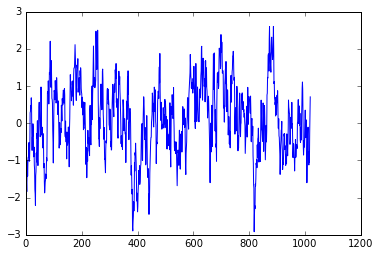

In [16]:
# Generalize: generate a time series with desired correlation matrix: the KL expansion!

def Color_Random_Sequence(num_samples, decay_factor):
    from scipy import stats
    from scipy.linalg import toeplitz
    import numpy as np
    
    Expo_decay = stats.threshold([np.exp(-decay_factor*i) for i in range(num_samples)],0.0001,1,0)    
    C_y=toeplitz(Expo_decay)
    eig_val, eig_vec = np.linalg.eig(C_y)
    Coloring_matrix=np.dot(eig_vec,np.diag(np.sqrt(eig_val)))
    return(Coloring_matrix)

def Estimated_Autocorrelation(x):
    # http://stackoverflow.com/questions/14297012/estimate-autocorrelation-using-python
    
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

num_samples = 1020
decay_factor = 0.1 
 
x = np.random.randn(num_samples)
A = Color_Random_Sequence(num_samples, decay_factor)    
C_y_check = np.dot(A, A.T)
    
y = np.dot(A, x)
y2=np.random.multivariate_normal(np.zeros(len(x)), C_y_check)

# plt.plot(Estimated_Autocorrelation(y2))
plt.plot(y2)

## Random Walks

These are remarkably easy to generate time-series which model many different phenomena. The simplest form is the one-dimensional, binary-state random walk, and is the simplest gateway into powerful and prevalent recursive models:

### My State at Time t = My State at Time (t+1) + Random Perturbation

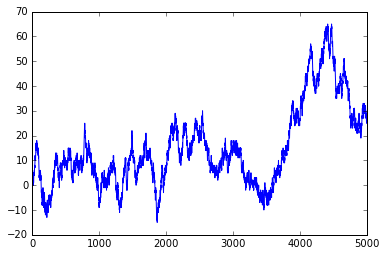

In [26]:
import random as rm
import matplotlib.pylab as plt
drift = 0.0
L=[-2,-1,1,2];
L=[-1,1]
def Random_Walk(x, L, drift, n):
    a=[]   
    for i in range(n):
        x = x + rm.choice(L) + drift 
        a.append(x)
    return(a)
        
plt.plot(Random_Walk(5, L,drift,5000))

## Markov Chains and Processes

These are powerful tools for modeling and generating correlated sequences. In general, correlated processes have the following structure: 


####  State at Time (i+1) = function(State at Time (i), State at Time (i-1), ..., State at Time Immemorial)

so that the next state is a complicated entity that depends on all previous states of the system and therefore requires a sizable memory and expensive computational resources. Markov processes go one step beyond independent processes and one step behind this complex scenario, by assuming that next state depends only the previous state (or previous $n$ states in general). 

#### State at Time (i+1) = function(State at Time (i) only)

In [45]:
Image(url='http://1.bp.blogspot.com/-_v4xzlnHqWk/T4jy6aaBEhI/AAAAAAAAAo8/_L0D5t0VS7o/s1600/first.png', width=500, height=500)

Notice the similarity and generalization of the Markov Chain above to the Random Walk mentioned earlier. Whereas we retain the same structure of the future depending only on the current state, we now have a richer State Transition Matrix (STM) to jump between different states. 

There is no end to the special cases and additional structures that Markov Processes can encompass. One extension worth mentioning is the familiar Hidden Markov Model (HMM), where one does not have access to the states themselves, but only observes the outputs of the states. For example, the states could be letters in the alphabet, and all the microphone observes are sound waveforms. The problem, for instance, can then become to estimate the likelihood of a person uttering the letter A followed by letter B, given a particular recorded waveform, verses the likelihood of uttering the letter A followed by letter D. This extended model requires an additional Output Transition Matrix (OTM) in addition to the earlier PTM.


In [46]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/HiddenMarkovModel.svg/2000px-HiddenMarkovModel.svg.png', width=700, height=700)

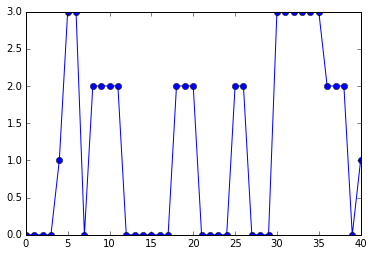

In [47]:
def Markov_Process(n,S_0,STP):
    
    from scipy import stats
    
    xk = np.arange(len(STP))
    pk = tuple(STP[S_0])
    custm = stats.rv_discrete(name='custm', values=(xk, pk))    
    S_n = int(custm.rvs(size=1))
    Markov_Process = [S_n]
    
    for i in range(n):
        pk = tuple(STP[S_n])
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        S_n = int(custm.rvs(size=1))
        Markov_Process.append(S_n)
    return(Markov_Process)

def Normalize_Rows_Matrix(Mat):   
    row_sums = Mat.sum(axis=1)
    return(Mat / row_sums[:, np.newaxis])
    
STP=Normalize_Rows_Matrix(np.array([[0.9,0.1,0.1,0.1],[0.1,1.8,0.1,0.2],[0.6,0.1,0.9,0.1],[0.25,0.25,0.25,1.25]]))
#n=5
#STP=Normalize_Rows_Matrix(np.random.random([n,n]))
plt.plot(Markov_Process(40, 0, STP),'-ob') 



If the probability of remaining in the same state is high, you will notice a long run of values in the time series that are "stuck" in that states. In the long run, the frequency of being in a particular state of the system relates to the eigenvalues of the STM. You can notice the change on the histogram below with different variations in the STM above.

<Container object of 4 artists>

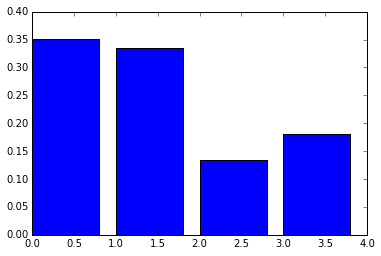

In [48]:
import collections
hist=collections.Counter(Markov_Process(4000, 2, STP))
plt.bar(hist.keys(),np.divide(hist.values(),float(sum(hist.values()))))


## Autoregressive Models

Another useful model for time-series is one where a current value depends deterministically on $p$ preceeding values, weighted by some proceedure, such that more recent values are typically assigned higher weights than older ones. This autonomy, or dependency of the process on its own previous values, grants it the name "auto-regressive" (AR) model. 


In [49]:
Image(url='https://upload.wikimedia.org/math/f/0/6/f06ba0e2d8668944406852d7f72ac2f1.png')

Notice the difference between the AR model and the previous Markov models, where randomness only enters the picture here by the random noise $\epsilon_{t}$, with no uncertainty in selecting the previous states or thier wheights in the AR model.

A well-known generalization to this model is the Auto-Regressive-Moving-Average (ARMA) model which includes a weighted sum over a sequence of noise components $\epsilon_{t}, \epsilon_{t-1}, ..., \epsilon_{t-M}$ in addition to the weighted sum in the AR model.


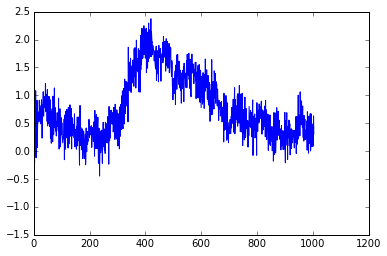

In [50]:
def AR_model(n, normalized_weights, alpha):
    
    window_length = len(normalized_weights)
    x = np.random.randn(window_length)
    process = list(x)
    for i in range(n):
        x=np.append(x[1:],np.dot(normalized_weights,x)+alpha*np.random.randn())
        process.append(x[-1])
    return(process)

w = [0.61, 0.30, 0.250, 0.0251,0.00]
w = w/np.linalg.norm(w,1)
plt.plot(AR_model(1000, w, 0.21))  

## Brownian Motion: Random Walks in the Limit

What if the current value does not only depend on the last value like a random walk, or the last $p$ values in a $p$-order Markov process or Auto-regressive model, but instead depended on $\textit{all}$ previous values? For example, if we simply sum all previous values as we go, this corresponds to equal weights $1/n$ to each of them, and we converge in the limit to Weiner process, which describes the physical phenomena of Brownian motion (Refer to [4] for details). 

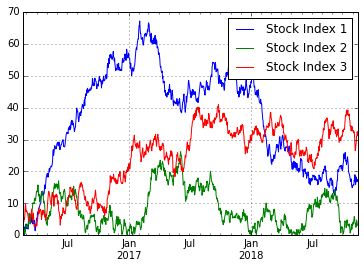

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

idx=pd.date_range('2/20/2016', periods=1000)
df = pd.DataFrame(np.random.randn(1000, 3), index = idx, columns=list(['Stock Index 1', 'Stock Index 2', 'Stock Index 3'])).cumsum().abs()
plt.figure(); df.plot();

## Regression: after we've generated a time-series model, what can be done?

Suppose we are not generating a time-series, but rather we're given a sequence and would like to find a model that describes the sequence in a useful way. A few key points are worth mentioning: 

1. Regression strategy depends on structure of the time-series model (order, memory, periodicity, etc.). 
2. There is an un-avoidable trade-off between model variance and bias. Generally, the more adaptive and elastic we make a model by increasing the number of its paramters, the smaller the bias or sum of squared errors between the model prediction and the actual values. However, this also means the variance of the predicted values will be higher, and so is the model complexity in general. Low bias is not always good however, and increasing complexity is not always virtuous, since this could lead to the fundamental problem of overfitting. 



In [52]:
Image(url='https://qph.is.quoracdn.net/main-qimg-e6481ee694cad889cdb7a8215b27c331?convert_to_webp=true')

In [53]:
Image(url='http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png', width=400, height=400)

### Predicting the future: LS and LMS

In [54]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/6/62/Lms_filter.svg', width=400, height=400)

### Least Square estimation:

In [55]:
Image(url='https://upload.wikimedia.org/math/b/8/c/b8cbbe1e46eb12b4362a2d7d272f6608.png')


### Recursive prediction: the Least Mean Square (LMS) estimator

In [56]:
Image(url='https://upload.wikimedia.org/math/c/8/8/c886458bb30fba49d20302e4fa1e5a14.png')

### References: 

[1] Series using Pandas: http://pandas.pydata.org/pandas-docs/stable/timeseries.html

[2] It's hard to mention random walks without bring up the name of the famous and controversial book
https://en.wikipedia.org/wiki/A_Random_Walk_Down_Wall_Street

[3] Neural Networks for Financial Forcasting: A Survey Paper: http://epublications.bond.edu.au/infotech_pubs/110/

[4] Relation between random walks and Brownian motion: http://www.samsi.info/sites/default/files/athreya_feb2010.pdf
